
### Alex Net Entropy and Marcenko-Pastur Law

http://math.mit.edu/~edelman/publications/random_matrix_theory_innovative.pdf



This time, I ensure W has norm 1


In [1]:
import numpy as np
import tensorflow as tf
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
print(sklearn.__version__)

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.19.1


In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K


model = Sequential()
model.add(Conv2D(96, (5, 5), input_shape=(28, 28, 3), kernel_initializer=
                 'glorot_normal', bias_initializer=Constant(0.1), padding=
                 'same', activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (5, 5), kernel_initializer='glorot_normal',
                 bias_initializer=Constant(0.1), padding='same',
                 activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(384, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(192, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='softmax'))



sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())



Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


weights/cifar10_alexnet.h5


### Show how to load the weight matrices

#### We care about layers 7 and 8

In [5]:
!ls weights/cifar10_alexnet.h5

weights/cifar10_alexnet.h5


In [6]:
model.load_weights('weights/cifar10_alexnet.h5')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

In [9]:
model.load_weights("weights/cifar10_alexnet.h5")
print(len(model.layers))
for il in [7,8,9]:
    print(il)
    W = model.layers[il].get_weights()[0]
    print(np.linalg.norm(W), np.linalg.matrix_rank(W))
        

10
7
24.322296 384
8
14.838495 192
9
5.8947635 10


### Matrix Entropy

http://www.pnas.org/content/97/18/10101.full


### <font color='red'> ensure W has trace 1 ?


In [48]:
def matrix_entropy(W, n=512):

    W=W/np.trace(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    rank = np.linalg.matrix_rank(W)
    p = sv*sv
    p = p/np.sum(p)
    
    if (rank==1):
        rank=1.000001
    entropy = - np.sum(p*np.log(p)) / np.log(rank) 
    return entropy


### Matrix Entropy as a function of Epoch for a single run

### <font color='red'>NOT AT ALL INTERESTING</font>

In [18]:
!ls weights/alexnet.b16.id1.e*.h5 

weights/alexnet.b16.id1.e0.h5  weights/alexnet.b16.id1.e26.h5
weights/alexnet.b16.id1.e1.h5  weights/alexnet.b16.id1.e27.h5
weights/alexnet.b16.id1.e10.h5 weights/alexnet.b16.id1.e28.h5
weights/alexnet.b16.id1.e11.h5 weights/alexnet.b16.id1.e29.h5
weights/alexnet.b16.id1.e12.h5 weights/alexnet.b16.id1.e3.h5
weights/alexnet.b16.id1.e13.h5 weights/alexnet.b16.id1.e30.h5
weights/alexnet.b16.id1.e14.h5 weights/alexnet.b16.id1.e31.h5
weights/alexnet.b16.id1.e15.h5 weights/alexnet.b16.id1.e32.h5
weights/alexnet.b16.id1.e16.h5 weights/alexnet.b16.id1.e33.h5
weights/alexnet.b16.id1.e17.h5 weights/alexnet.b16.id1.e34.h5
weights/alexnet.b16.id1.e18.h5 weights/alexnet.b16.id1.e35.h5
weights/alexnet.b16.id1.e19.h5 weights/alexnet.b16.id1.e36.h5
weights/alexnet.b16.id1.e2.h5  weights/alexnet.b16.id1.e37.h5
weights/alexnet.b16.id1.e20.h5 weights/alexnet.b16.id1.e4.h5
weights/alexnet.b16.id1.e21.h5 weights/alexnet.b16.id1.e5.h5
weights/alexnet.b16.id1.e22.h5 weights/alexnet.b16.id1.e6.h5
weights/alex

In [87]:
run_id = 1
num_epochs = 38
epochs = np.arange(0,num_epochs)

every5_epochs = np.arange(0,num_epochs,5)
every5_epochs = np.append(every5_epochs,37)


In [61]:
entropies_w7, entropies_w8 = [], []
for epoch in epochs:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(run_id,epoch)
    model.load_weights(modelfile)
    W7 = model.layers[7].get_weights()[0]
    W8 = model.layers[8].get_weights()[0]
    entropies_w7.append(matrix_entropy(W7, n=384))
    entropies_w8.append(matrix_entropy(W8, n=192))

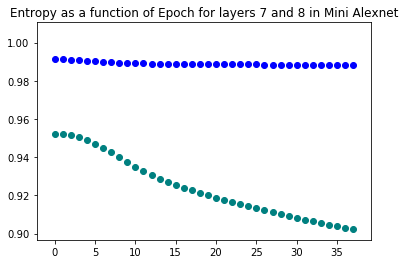

In [74]:
plt.scatter(epochs, entropies_w7, color='blue')
plt.scatter(epochs, entropies_w8, color='teal')
plt.title("Entropy as a function of Epoch for layers 7 and 8 in Mini Alexnet")

In [86]:
every5_epochs

array([ 0,  5, 10, 15, 20, 25, 30, 35])

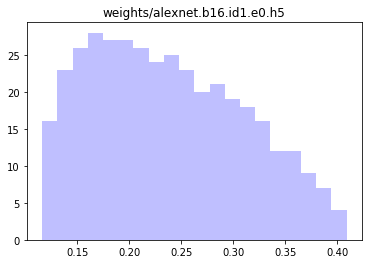

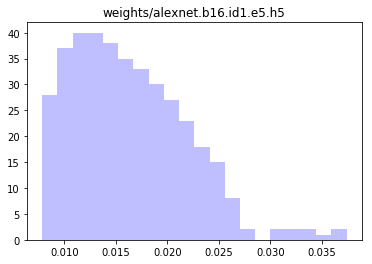

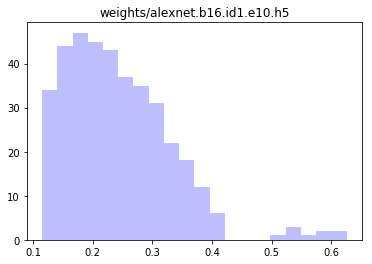

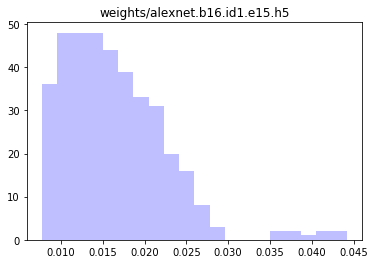

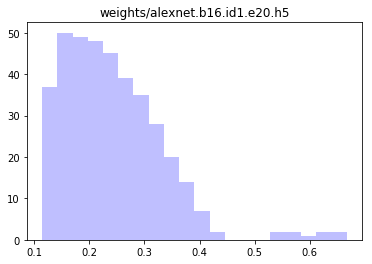

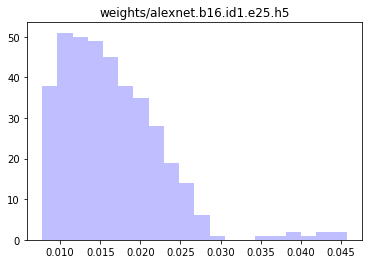

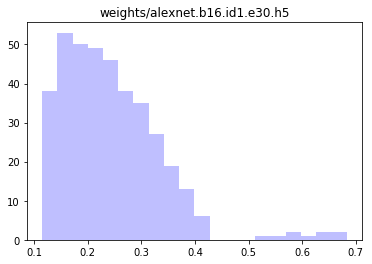

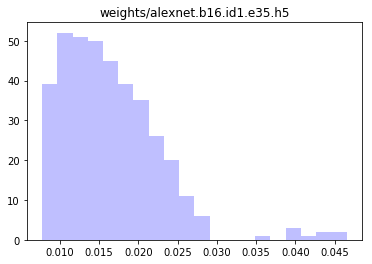

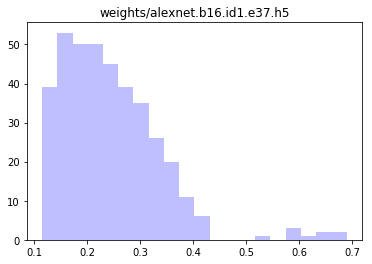

In [88]:
for epoch in every5_epochs:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(run_id,epoch)
    model.load_weights(modelfile)
    W7 = model.layers[7].get_weights()[0]
    n=384
    W = W7 / np.linalg.norm(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    ev = sv*sv
    #plt.hist(sv, bins=20, alpha=0.25, color='blue');

    plt.hist(ev, bins=20, alpha=0.25, color='blue');
    plt.title(modelfile)
    plt.show()

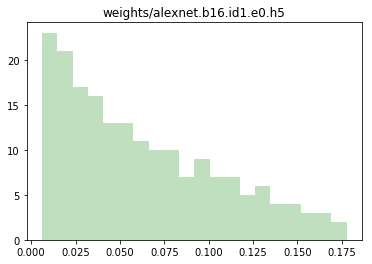

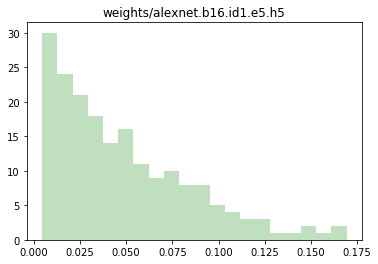

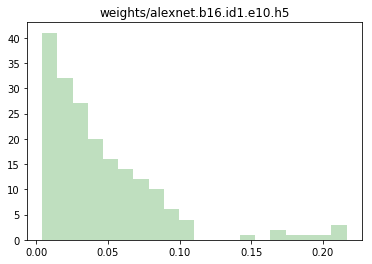

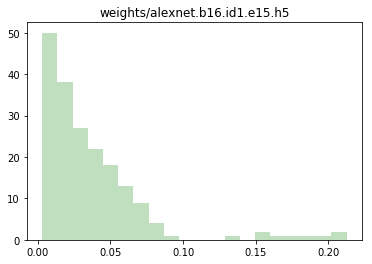

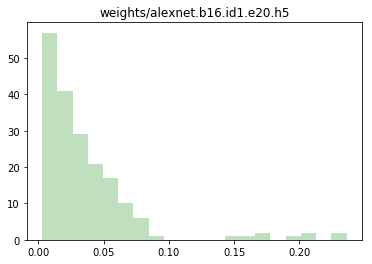

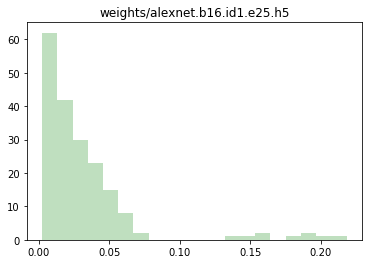

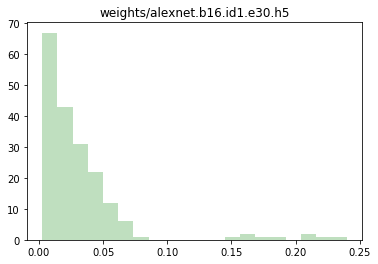

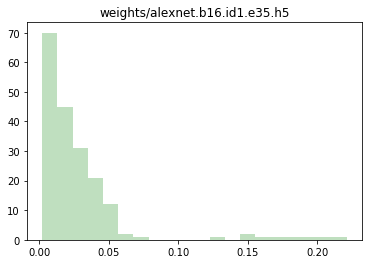

In [82]:
for epoch in every5_epochs:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(run_id,epoch)
    model.load_weights(modelfile)
    W8 = model.layers[8].get_weights()[0]
    n=192
    W = W8 / np.linalg.norm(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    ev = sv*sv
    #plt.hist(sv, bins=20, alpha=0.25, color='blue');

    plt.hist(ev, bins=20, alpha=0.25, color='green');
    plt.title(modelfile)
    plt.show()

### TODO

- make this into a 3d Plot
- average over all ids
- repeat for MLP3


cifar10_alexnet.h5


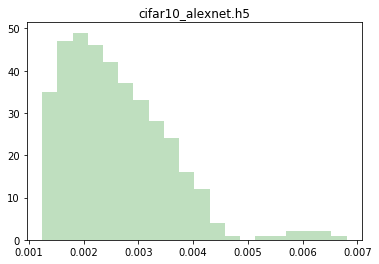

alexnet.b2.final.h5


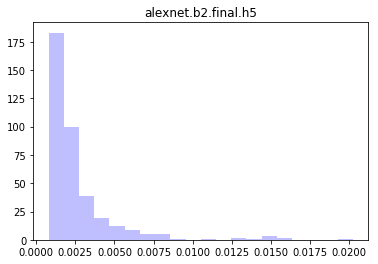

cifar10_alexnet_wd.h5


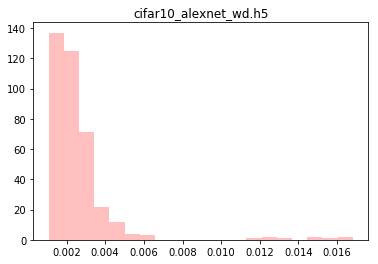

cifar10_alexnet_rand_labels.h5


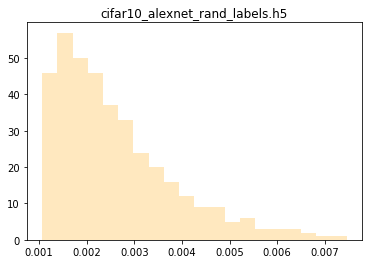

alexnet.b512.final.h5


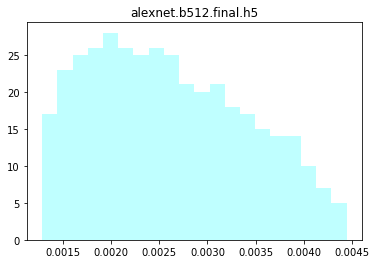

alexnet.b16.rand100.final.h5


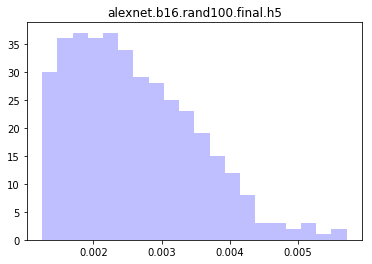

alexnet.b2.rand100.final.h5


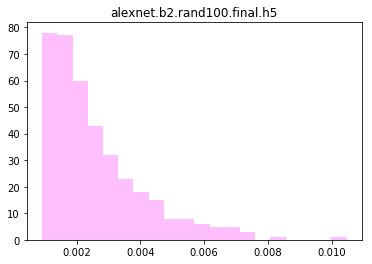

In [47]:
for modelfile, color in zip(modelfiles, colors):
    print(modelfile)
    model.load_weights("weights/{}".format(modelfile))
    W = model.layers[7].get_weights()[0]
    n = 384
    W = W / np.linalg.norm(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    ev = sv*sv
    plt.hist(ev, bins=20, alpha=0.25, color=color);
    plt.title(modelfile)
    plt.show()

In [40]:
modelfiles = ["cifar10_alexnet.h5", "alexnet.b2.final.h5", "cifar10_alexnet_wd.h5","cifar10_alexnet_rand_labels.h5", "alexnet.b512.final.h5" ,"alexnet.b16.rand100.final.h5", "alexnet.b2.rand100.final.h5"]
colors = ["green", "blue", "red", "orange", "cyan", "blue", "magenta"]

cifar10_alexnet.h5


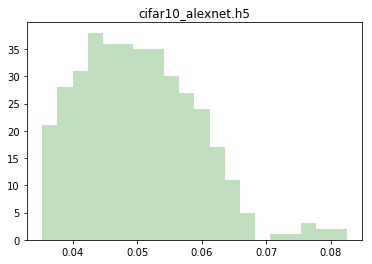

alexnet.b2.final.h5


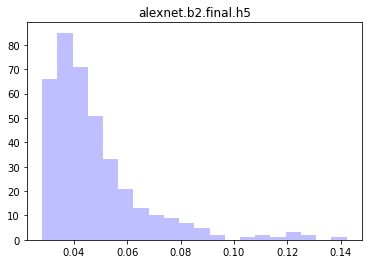

cifar10_alexnet_wd.h5


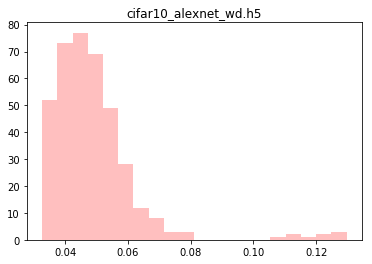

cifar10_alexnet_rand_labels.h5


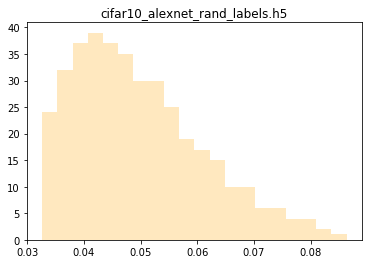

alexnet.b512.final.h5


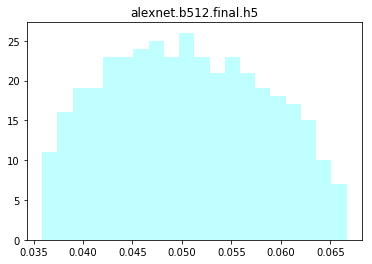

alexnet.b16.rand100.final.h5


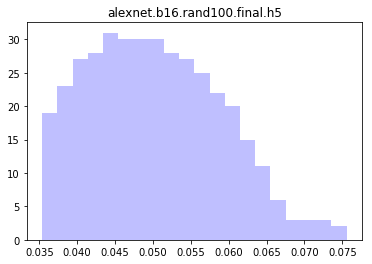

alexnet.b2.rand100.final.h5


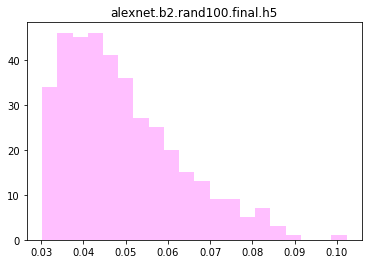

In [41]:
for modelfile, color in zip(modelfiles, colors):
    print(modelfile)
    model.load_weights("weights/{}".format(modelfile))
    W = model.layers[7].get_weights()[0]
    n = 384
    W = W / np.linalg.norm(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    plt.hist(sv, bins=20, alpha=0.25, color=color);
    plt.title(modelfile)
    plt.show()